In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from scipy import stats, signal
from scipy.signal import hilbert
from numpy.lib.recfunctions import append_fields, merge_arrays
from scipy.stats import circmean
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.font_manager as fm

import sys
import pickle
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LinearRegression as LR
import matplotlib.colors as clrs
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab as pyl
from scipy.spatial.distance import pdist, squareform
from scipy.io import loadmat
import warnings; warnings.simplefilter('ignore')

([], [])

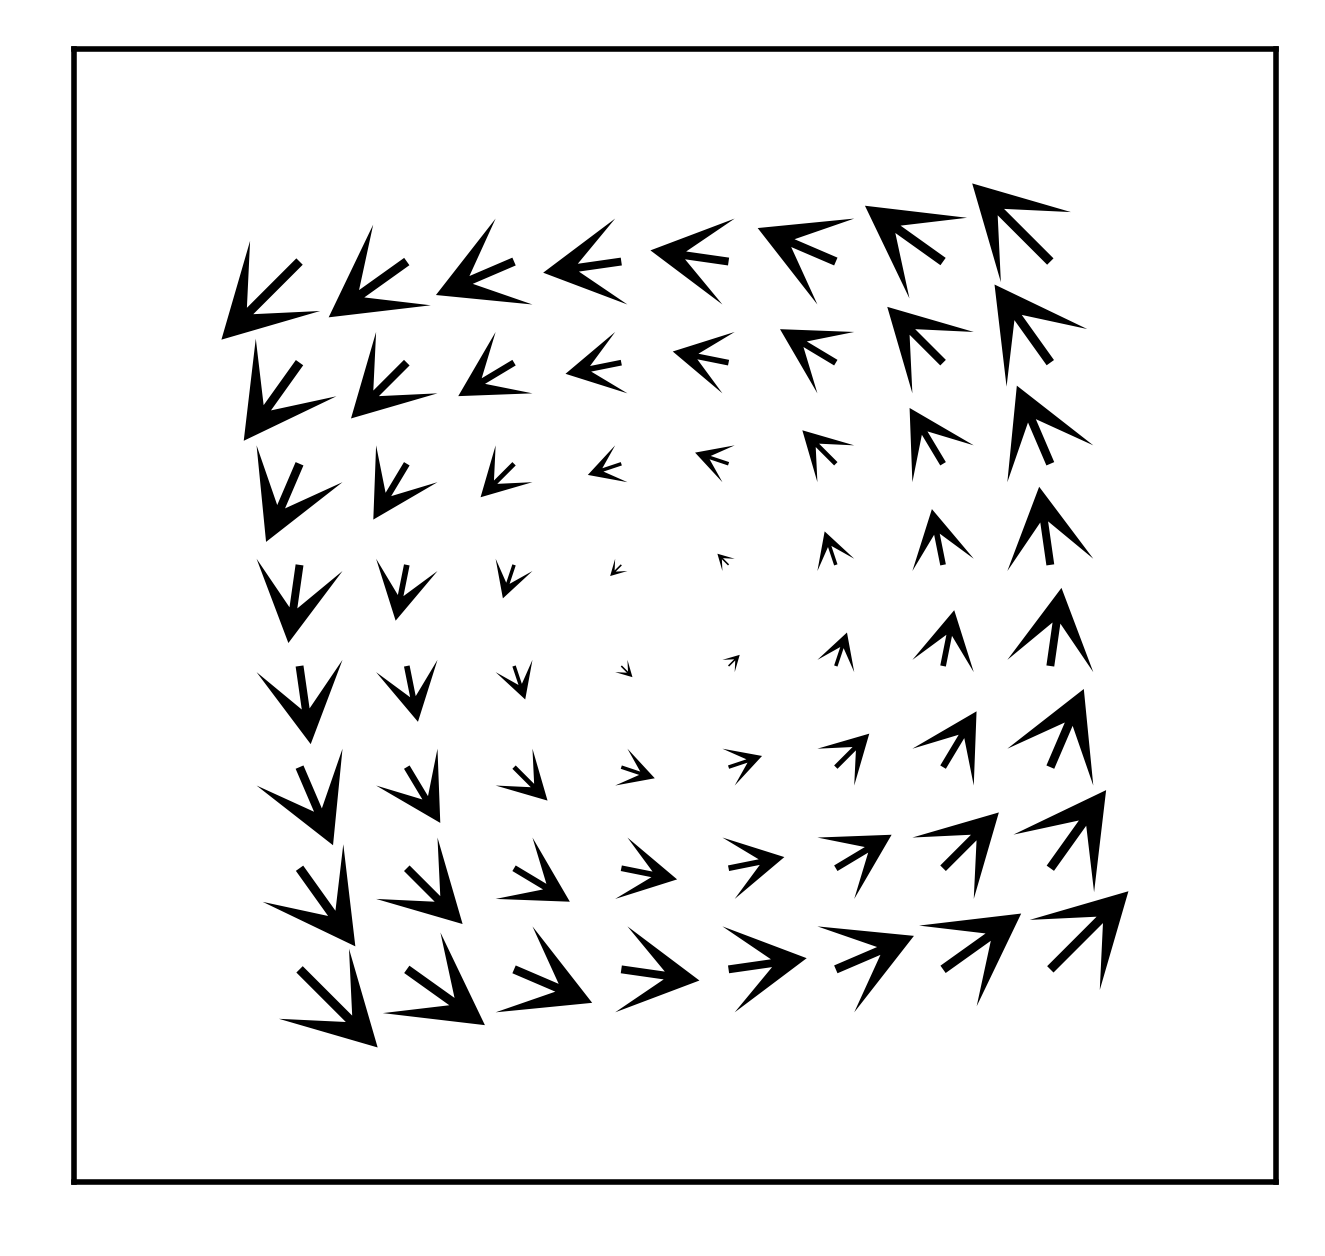

In [7]:
#Generate an example rotational wave 
ra = np.array([-2.5, 2.5, -2.5, 2.5]);
M = 8
N = 8
xval = np.linspace(ra[0], ra[1], num = M)
yval = np.linspace(ra[2], ra[3], num = N)
xg, yg = np.meshgrid(xval, yval)

plt.rcParams['font.family'] = ['DejaVu Serif']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({'font.size': 20})

xlimit = 4
ylimit = 4

scale = 16






#Circular (counter-clockwise)
F1g = np.zeros((M, N))
F2g = np.zeros((M, N))
for i_grid in range(0, M, 1):
    for j_grid in range(0, N, 1):
        F1g[i_grid, j_grid] = -yg[i_grid, j_grid]
        F2g[i_grid, j_grid] = xg[i_grid, j_grid]

dir_x_spiral = F1g
dir_y_spiral = F2g

fig = plt.figure(figsize=(3.1,3), dpi= 500) 

plt.quiver(xg,yg,F1g,F2g, scale=scale, scale_units='inches', headwidth = 11, headlength = 10)
plt.xlim([-xlimit, xlimit])
plt.ylim([-ylimit, ylimit])
plt.xticks([])
plt.yticks([])

([], [])

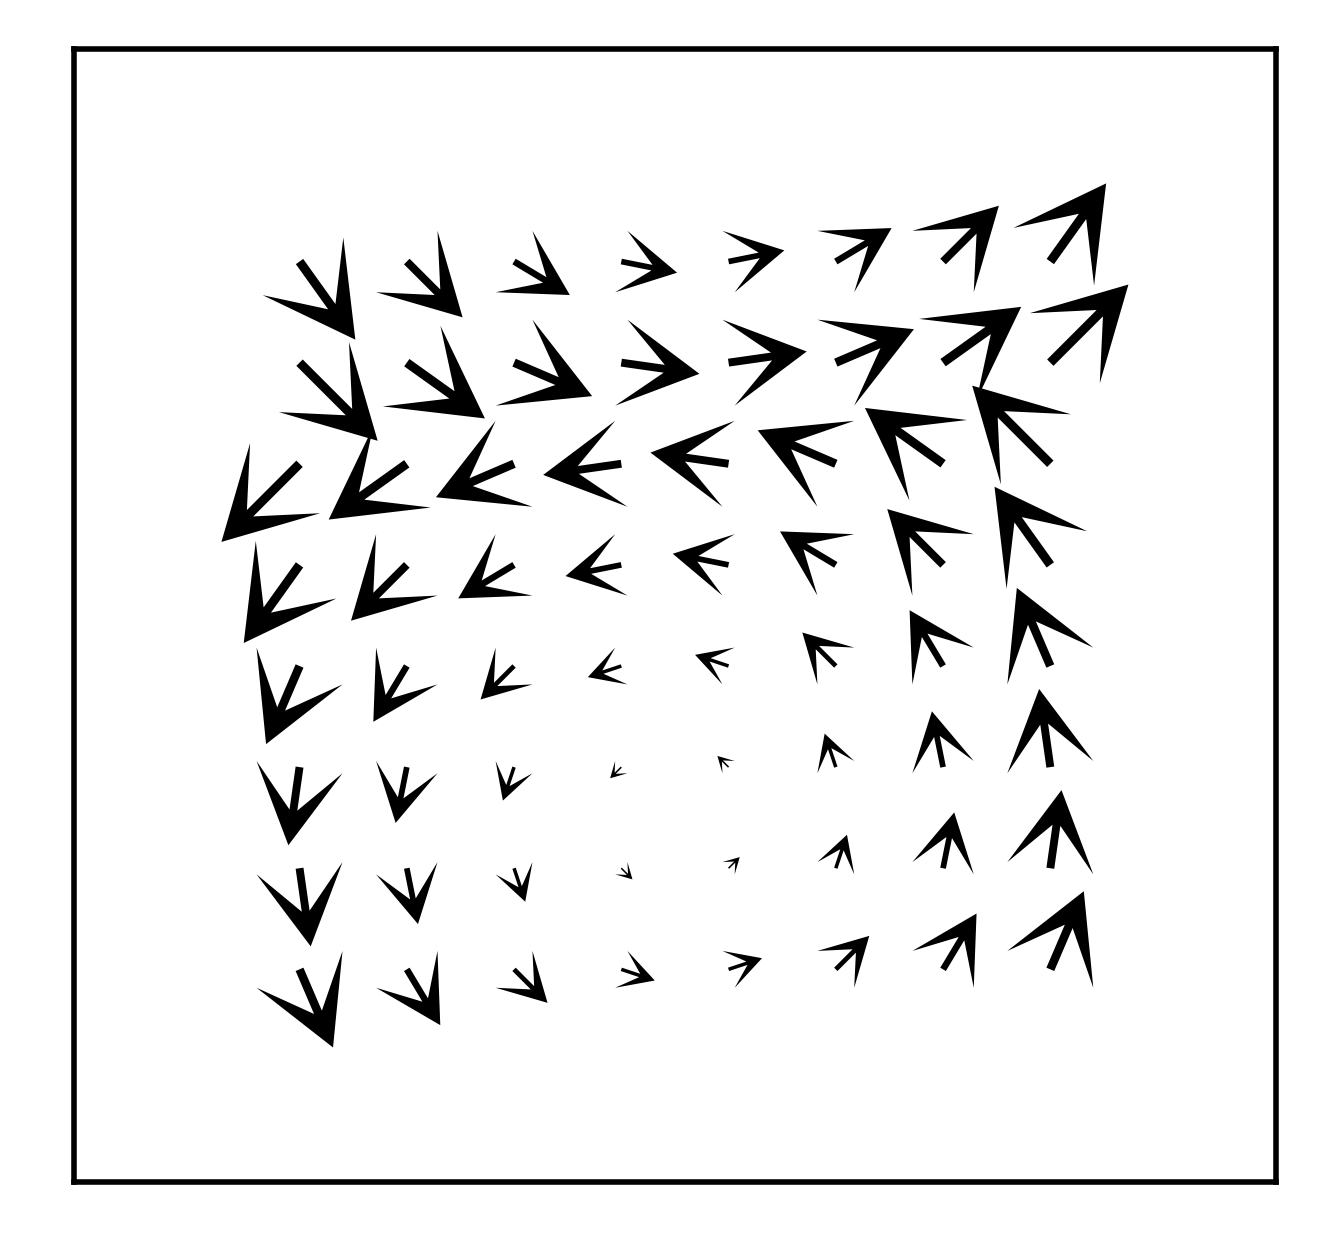

In [8]:
#Generate circularly shifted rotational wave 
v_shift = -2
h_shift = 0

dir_x_spiral = np.roll(F1g, v_shift, axis=0)
dir_y_spiral = np.roll(F2g, v_shift, axis=0)

dir_x_spiral = np.roll(dir_x_spiral, h_shift, axis=1)
dir_y_spiral = np.roll(dir_y_spiral, h_shift, axis=1)

#plot 
fig = plt.figure(figsize=(3.1,3), dpi= 500) 

plt.quiver(xg,yg,dir_x_spiral,dir_y_spiral, scale=scale, scale_units='inches', headwidth = 11, headlength = 10)
plt.xlim([-xlimit, xlimit])
plt.ylim([-ylimit, ylimit])
plt.xticks([])
plt.yticks([])

In [9]:
#Run ICA on circularly shifted rotational wave 
from __future__ import division
import pdb,os,time,warnings
import numpy as np
from math import log
from numpy.linalg import *
from numpy.random import rand

F1g = np.zeros((M, N))
F2g = np.zeros((M, N))
for i_grid in range(0, M, 1):
    for j_grid in range(0, N, 1):
        F1g[i_grid, j_grid] = -yg[i_grid, j_grid]
        F2g[i_grid, j_grid] = xg[i_grid, j_grid]
    
F1g_gt = F1g/np.max(np.abs(F1g))
F2g_gt = F2g/np.max(np.abs(F2g))

dir_x_spiral = F1g
dir_y_spiral = F2g

err_val_shuffled = []

total_perm = 500 
for i_perm in range(0, total_perm, 1): 
    
    n_times = 50
    vf = (np.empty(((M, N, n_times))) + 1j*np.empty(((M, N, n_times)))).reshape((M*N, n_times))    

    for i_times in range(0, n_times, 1): 

        v_shift = np.random.permutation(8)[0]
        h_shift = np.random.permutation(8)[0]

        dir_x_spiral = np.roll(F1g, v_shift, axis=0)
        dir_y_spiral = np.roll(F2g, v_shift, axis=0)

        dir_x_spiral = np.roll(dir_x_spiral, h_shift, axis=1)
        dir_y_spiral = np.roll(dir_y_spiral, h_shift, axis=1)

        dir_spiral = dir_x_spiral + 1j*dir_y_spiral
        dir_spiral_noise = dir_spiral + 0.5*(np.random.standard_normal((M,N)) + 1j*np.random.standard_normal((M,N)))
        vf[:, i_times] = dir_spiral_noise.reshape(M*N)






    #ICA
    #initialization matrix
    n = np.shape(vf)[0]
    init_mat = np.zeros((n,n),dtype=np.complex)
    for k in range(n):
        np.random.seed(k+100)
        init_mat[:,k] = np.random.rand(n)+1j*np.random.rand(n)

    def abs_sqr(W,X):
        return abs(W.conj().T.dot(X))**2

    X=vf
    epsilon=.0000001
    algorithm='deflation'
    max_iter=100
    tol=1e-12
    whiten=False
    w_init=None
    n_components=None

    n,m  = X.shape

    if n_components!=None:
        n = n_components

    if whiten:
        X-=X.mean(1,keepdims=True)
        Ux,Sx = eig(np.cov(X))
        K     = np.sqrt(inv(np.diag(Ux))).dot(Sx.conj().T)[:n]
        X     = K.dot(X)
        del Ux,Sx
    else:
        K = None

    EG = np.ones((n,max_iter))*np.nan

    if algorithm=='deflation':

        W = np.zeros((n,n),dtype=np.complex)

        for k in range(n):
            if w_init!=None:
            #if w_init.any():
                w = w_init[:,k]
            else:
                #np.random.seed(k)
                #w = np.random.rand(n,1)+1j*np.random.rand(n,1)
                w = (np.real(init_mat[:,k])+1j*np.imag(init_mat[:,k])).reshape((n,1))

            w/=norm(w)

            n_iter  = 0

            for i in range(max_iter):

                wold = np.copy(w)

                #derivative of the contrast function
                g  =  1/(epsilon+abs_sqr(w,X))
                #derivative of g
                dg = -1/(epsilon+abs_sqr(w,X))**2

                w  = (X * (w.conj().T.dot(X)).conj() * g).mean(1).reshape((n,1))-\
                     (g + abs_sqr(w,X) * dg).mean() * w

                del g,dg

                w/=norm(w)

                # Decorrelation
                w-=W.dot(W.conj().T).dot(w)
                w/=norm(w)

                EG[k,n_iter] = (np.log(epsilon+abs_sqr(w,X))).mean()

                n_iter+=1

                lim = (abs(abs(wold)-abs(w))).sum()
                if lim<tol:
                    break

            if n_iter==max_iter and lim>tol:
                warnings.warn('FastICA did not converge. Consider increasing '
                              'tolerance or the maximum number of iterations.')

            W[:,k] = w.ravel()

    Shat = W.conj().T.dot(X)

    #calculate energy percentage
    ic_vars = np.mean(np.abs(Shat**2), axis = 1)
    ic_vars_per = ic_vars*100/np.sum(ic_vars)

    #sort
    W_sorted = W[:, np.argsort(ic_vars_per)[::-1]]
    Shat_sorted = Shat[np.argsort(ic_vars_per)[::-1], :]
    ic_vars_per_sorted = ic_vars_per[np.argsort(ic_vars_per)[::-1]]



    w_all = Shat_sorted
    i_mode = 0
    mode_reshaped_ica = np.reshape(W_sorted[:, i_mode], (M, N))
    F1g = np.real(np.mean(w_all[i_mode, :]) * mode_reshaped_ica)
    F2g = np.imag(np.mean(w_all[i_mode, :]) * mode_reshaped_ica)

    F1g = F1g/np.max(np.abs(F1g))
    F2g = F2g/np.max(np.abs(F2g))

    err_val_shuffled.append((np.sum(np.square(F1g_gt - F1g)) + np.sum(np.square(F2g_gt - F2g)))/(M*N))

In [10]:
#Run ICA on original rotational wave  
from __future__ import division
import pdb,os,time,warnings
import numpy as np
from math import log
from numpy.linalg import *
from numpy.random import rand

F1g = np.zeros((M, N))
F2g = np.zeros((M, N))
for i_grid in range(0, M, 1):
    for j_grid in range(0, N, 1):
        F1g[i_grid, j_grid] = -yg[i_grid, j_grid]
        F2g[i_grid, j_grid] = xg[i_grid, j_grid]
    
F1g_gt = F1g/np.max(np.abs(F1g))
F2g_gt = F2g/np.max(np.abs(F2g))

dir_x_spiral = F1g
dir_y_spiral = F2g

err_val_spiral = []
    
n_times = 50
vf = (np.empty(((M, N, n_times))) + 1j*np.empty(((M, N, n_times)))).reshape((M*N, n_times))    

for i_times in range(0, n_times, 1): 

    dir_spiral = dir_x_spiral + 1j*dir_y_spiral
    dir_spiral_noise = dir_spiral + 0.5*(np.random.standard_normal((M,N)) + 1j*np.random.standard_normal((M,N)))
    vf[:, i_times] = dir_spiral_noise.reshape(M*N)






#ICA
#initialization matrix
n = np.shape(vf)[0]
init_mat = np.zeros((n,n),dtype=np.complex)
for k in range(n):
    np.random.seed(k+100)
    init_mat[:,k] = np.random.rand(n)+1j*np.random.rand(n)

def abs_sqr(W,X):
    return abs(W.conj().T.dot(X))**2

X=vf
epsilon=.0000001
algorithm='deflation'
max_iter=100
tol=1e-12
whiten=False
w_init=None
n_components=None

n,m  = X.shape

if n_components!=None:
    n = n_components

if whiten:
    X-=X.mean(1,keepdims=True)
    Ux,Sx = eig(np.cov(X))
    K     = np.sqrt(inv(np.diag(Ux))).dot(Sx.conj().T)[:n]
    X     = K.dot(X)
    del Ux,Sx
else:
    K = None

EG = np.ones((n,max_iter))*np.nan

if algorithm=='deflation':

    W = np.zeros((n,n),dtype=np.complex)

    for k in range(n):
        if w_init!=None:
        #if w_init.any():
            w = w_init[:,k]
        else:
            #np.random.seed(k)
            #w = np.random.rand(n,1)+1j*np.random.rand(n,1)
            w = (np.real(init_mat[:,k])+1j*np.imag(init_mat[:,k])).reshape((n,1))

        w/=norm(w)

        n_iter  = 0

        for i in range(max_iter):

            wold = np.copy(w)

            #derivative of the contrast function
            g  =  1/(epsilon+abs_sqr(w,X))
            #derivative of g
            dg = -1/(epsilon+abs_sqr(w,X))**2

            w  = (X * (w.conj().T.dot(X)).conj() * g).mean(1).reshape((n,1))-\
                 (g + abs_sqr(w,X) * dg).mean() * w

            del g,dg

            w/=norm(w)

            # Decorrelation
            w-=W.dot(W.conj().T).dot(w)
            w/=norm(w)

            EG[k,n_iter] = (np.log(epsilon+abs_sqr(w,X))).mean()

            n_iter+=1

            lim = (abs(abs(wold)-abs(w))).sum()
            if lim<tol:
                break

        if n_iter==max_iter and lim>tol:
            warnings.warn('FastICA did not converge. Consider increasing '
                          'tolerance or the maximum number of iterations.')

        W[:,k] = w.ravel()

Shat = W.conj().T.dot(X)

#calculate energy percentage
ic_vars = np.mean(np.abs(Shat**2), axis = 1)
ic_vars_per = ic_vars*100/np.sum(ic_vars)

#sort
W_sorted = W[:, np.argsort(ic_vars_per)[::-1]]
Shat_sorted = Shat[np.argsort(ic_vars_per)[::-1], :]
ic_vars_per_sorted = ic_vars_per[np.argsort(ic_vars_per)[::-1]]



w_all = Shat_sorted
i_mode = 0
mode_reshaped_ica = np.reshape(W_sorted[:, i_mode], (M, N))
F1g = np.real(np.mean(w_all[i_mode, :]) * mode_reshaped_ica)
F2g = np.imag(np.mean(w_all[i_mode, :]) * mode_reshaped_ica)

F1g = F1g/np.max(np.abs(F1g))
F2g = F2g/np.max(np.abs(F2g))

err_val_spiral.append((np.sum(np.square(F1g_gt - F1g)) + np.sum(np.square(F2g_gt - F2g)))/(M*N))

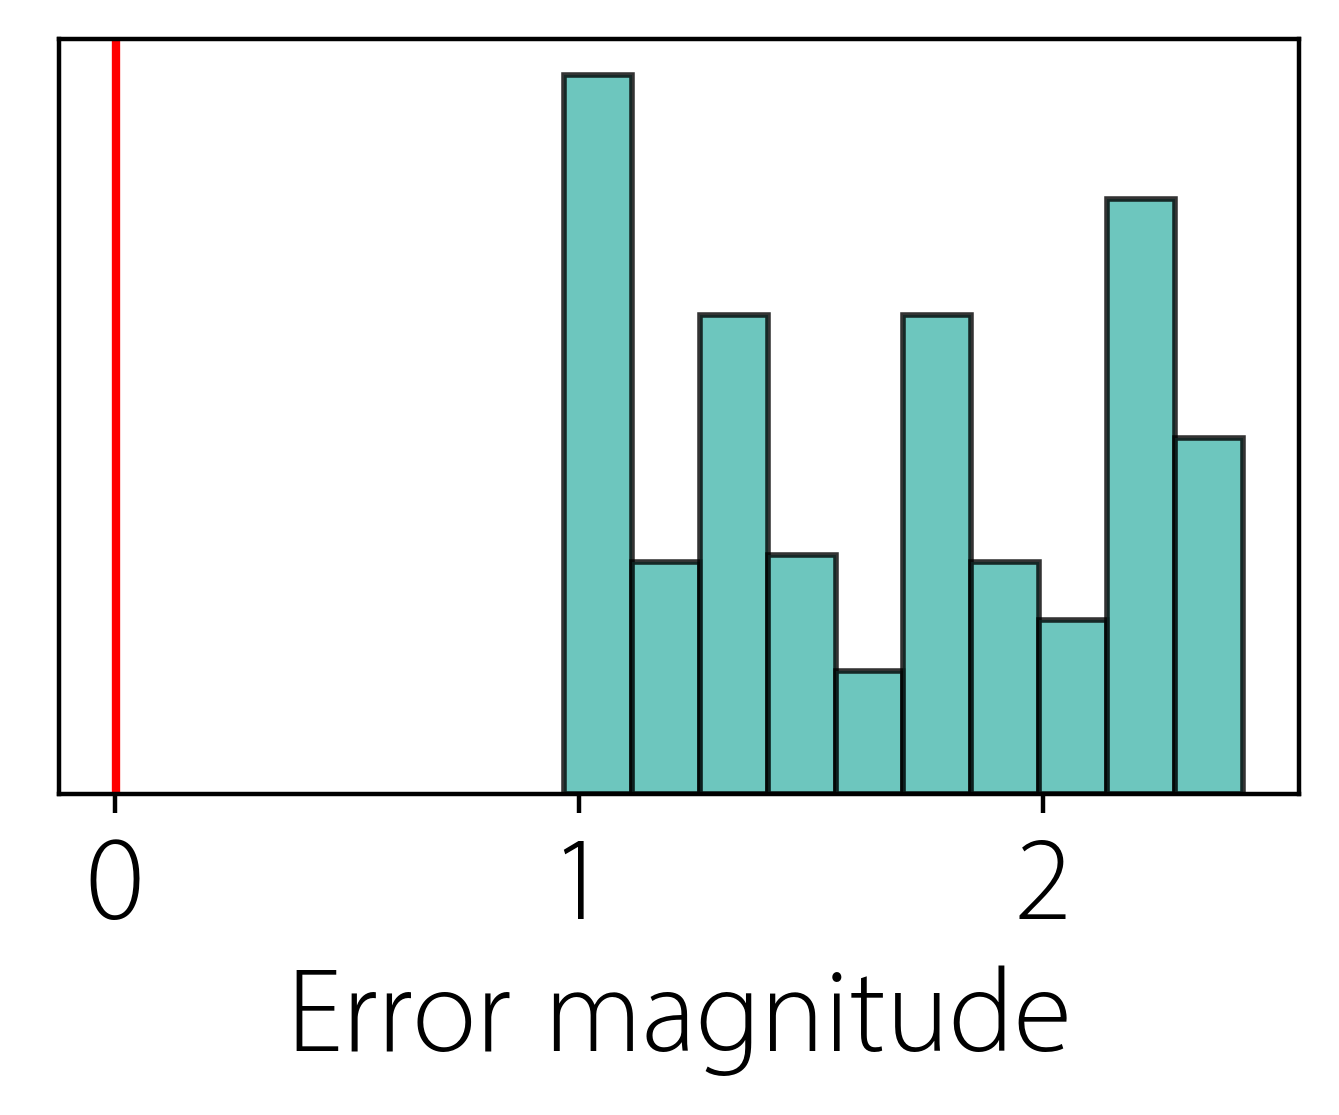

In [12]:
import matplotlib.font_manager as fm

%matplotlib inline
fig = plt.figure(figsize=(4,2.5), dpi= 400)
n_bins = 10

prop = fm.FontProperties(fname='/home1/anup.das/myriad-arabic-light.otf')
plt.hist(err_val_shuffled, color = '#48b8ae', bins = n_bins, edgecolor='black', alpha = 0.8)
plt.xlabel('Error magnitude', fontproperties = prop, fontsize = 30)
plt.xticks(fontproperties = prop, fontsize = 30)
plt.yticks([], fontproperties = prop, fontsize = 30)
plt.locator_params(axis='x', nbins=5)
plt.axvline(x=err_val_spiral, color='r', linestyle='-')
plt.show()